# Decision Tree Classifier
### 2301ai02 Anshurup gupta

In [136]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

# Optionally, visualize the decision tree
from sklearn import tree
from sklearn.metrics import accuracy_score

#### Data Pre processing

In [137]:
# Load the Iris dataset
iris = load_iris()

def data_check(data_set):
    print(f"Feature names: {data_set.feature_names}")
    print(f"Target names: {data_set.target_names}") # 0, 1, 2

    # Get unique values and their counts
    vals, counts = np.unique(data_set.target, return_counts=True)

    for val, c in zip(vals, counts):
        print(f"target: {val}, count: {c}")
    print(f"5 rows data: \n{data_set.data[:5]}")
    print(f"5 rows target: \n{data_set.target[:5]}")
    print()
data_check(iris)

num = 50

def pre_processing(data_set):
    X_data = data_set.data
    y_data = data_set.target

    # making dataSet only of 0 and 1
    y_data = y_data[:(2 * num)]
    X_data = X_data[:(2 * num)]

    # normalise if needed
    min_val = X_data.min(axis = 0)
    max_val = X_data.max(axis = 0)
    print(min_val, max_val, "\n")

    #X_data = (X_data - min_val) / (max_val - min_val)
    return X_data, y_data, iris.target_names[:2]

iris.data, iris.target, iris.target_names = pre_processing(iris)
data_check(iris)

def test_train_div(dataSet, test_train_ratio = 0.8):
    index = int(test_train_ratio * num)

    X_data = dataSet.data
    Y_data = dataSet.target

    arr1 = X_data[:index]
    arr2 = X_data[num:(num + index)]
    X_train = np.vstack((arr1, arr2))

    arr1 = X_data[index:num]
    arr2 = X_data[(num + index):(2 * num)]
    X_test = np.vstack((arr1, arr2))

    arr1 = Y_data[:index]
    arr2 = Y_data[num:(num + index)]
    Y_train = np.append(arr1, arr2, axis = 0) 

    arr1 = Y_data[index:num]
    arr2 = Y_data[(num + index):(2 * num)]
    Y_test = np.append(arr1, arr2, axis = 0) 

    return X_train, Y_train, X_test, Y_test

ratio = 0.8
X_train, Y_train, X_test, Y_test = test_train_div(iris, ratio)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
target: 0, count: 50
target: 1, count: 50
target: 2, count: 50
5 rows data: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
5 rows target: 
[0 0 0 0 0]

[4.3 2.  1.  0.1] [7.  4.4 5.1 1.8] 

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor']
target: 0, count: 50
target: 1, count: 50
5 rows data: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
5 rows target: 
[0 0 0 0 0]



#### Decision Tree

In [138]:
class decisionTree:
    def __init__(self, dataSet, dataTarget, max_depth, curr_depth = 1):
        self.depth = curr_depth
        self.max_depth = max_depth

        self.terminal = False
        self.LsubTree = None
        self.RsubTree = None

        self.best_split(dataSet, dataTarget)
        self.build_tree(dataSet, dataTarget)

    def build_tree(self, dataSet, dataTarget):
        if(not self.terminal):
            num = len(dataTarget)
            LdataSet, LdataTarget = [], []
            RdataSet, RdataTarget = [], []

            for sample in range(num):
                if(dataSet[sample][self.col] > self.threshold):
                    RdataSet.append(dataSet[sample])
                    RdataTarget.append(dataTarget[sample])
                else:
                    LdataSet.append(dataSet[sample])
                    LdataTarget.append(dataTarget[sample])

            if(self.depth < self.max_depth):
                self.LsubTree = decisionTree(LdataSet, LdataTarget, self.max_depth, self.depth + 1)
                self.RsubTree = decisionTree(RdataSet, RdataTarget, self.max_depth, self.depth + 1)
            else:
                self.value = 0 if(len(LdataTarget) > len(RdataTarget)) else 1
                self.terminal = True        

    def best_split(self, dataSet, dataTarget):
        num_data = len(dataTarget)

        # Get unique values and their counts
        vals, counts = np.unique(dataTarget, return_counts=True)
        print(vals)
        if(len(vals) == 1):
            self.terminal = True
            self.value = vals[0]
            return

        # entropy of dataSet
        data_entropy = self.entropy(counts[1] / num_data, counts[0] / num_data)
        print("data entropy: ",data_entropy)
        best_IG = 0

        cols = dataSet.shape[1]
        min_val = dataSet.min(axis = 0)
        max_val = dataSet.max(axis = 0)

        for col in range(cols):
            threshold = min_val[col]
            local_t = 0
            while(threshold < max_val[col]):
                
                # Probability of left, right of Yes\No
                LpY, LpN, RpY, RpN = 0, 0, 0, 0

                # Probability of left, right
                Lp, Rp = 0, 0

                # finding the yes / No table for 0 , 1
                for sample in range(num_data):
                    if(dataSet[sample][col] > threshold):
                        Rp += 1
                        if(dataTarget[sample] == 1):
                            RpY += 1
                        else:
                            RpN += 1
                    else:
                        Lp += 1
                        if(dataTarget[sample] == 1):
                            LpY += 1
                        else:
                            LpN += 1

                # information gain and update
                col_IG = data_entropy
                if(Lp != 0):
                    col_IG -= (Lp / num_data) * self.entropy(LpY / Lp, LpN / Lp) 
                if(Rp != 0):
                    col_IG -= (Rp / num_data) * self.entropy(RpY / Rp, RpN / Rp)
                
                if(col_IG >= best_IG or best_IG == 0):
                    best_IG = col_IG

                    self.col = col
                    self.threshold = threshold
                    local_t = threshold

                threshold += 0.1
            print(f"information gain: {iris.feature_names[col]} = {best_IG:.2f}, threshold: {local_t:.3f}")
        print()

    # calculate entropy
    def entropy(self, pY, pN):
        val = 0
        if(pY > 0):
            val += pY * np.log2(pY)
        if(pN > 0):
            val += pN * np.log2(pN)
        return -val

    # predict decision
    def predict_decision(self, x_instance):
        if(self.terminal):
            return self.value
        else:
            if(x_instance[self.col] > self.threshold):
                return self.RsubTree.predict_decision(x_instance)
            else:
                return self.LsubTree.predict_decision(x_instance)

    # test decision
    def test_DecisionTree(self, dataSet, dataTarget):
        # Predict the target labels for the test set
        Y_pred = []
        for sample in dataSet:
            Y_pred.append(self.predict_decision(sample))

        # Evaluate the accuracy of the model
        accuracy = accuracy_score(Y_pred, dataTarget)
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print()

    # plot
    def plot(self):
        if(self.terminal):
            print("value: ", iris.target_names[self.value])
        else:
            print(f"information gain: {iris.feature_names[self.col]}")
            for i in range(self.depth):
                print(" ", end = "")
            print("|")
            for i in range(self.depth):
                print(" ", end = "")
            print("|--> ", end=" ")
            self.LsubTree.plot()
            for i in range(self.depth):
                print(" ", end = "")
            print("|--> ", end=" ")
            self.RsubTree.plot()

dT = decisionTree(X_train, Y_train, 3)
dT.test_DecisionTree(X_test, Y_test)
dT.plot()

print()
for i in range(len(Y_test)):
    print("predict: ",iris.target_names[dT.predict_decision(X_test[i])],"true label: ",iris.target_names[Y_test[i]])


[0 1]
data entropy:  1.0
information gain: sepal length (cm) = 0.49, threshold: 5.500
information gain: sepal width (cm) = 0.49, threshold: 0.000
information gain: petal length (cm) = 1.00, threshold: 3.200
information gain: petal width (cm) = 1.00, threshold: 1.000

[0]
[1]
Accuracy: 100.00%

information gain: petal width (cm)
 |
 |-->  value:  setosa
 |-->  value:  versicolor

predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  setosa true label:  setosa
predict:  versicolor true label:  versicolor
predict:  versicolor true label:  versicolor
predict:  versicolor true label:  versicolor
predict:  versicolor true label:  versicolor
predict:  versicolor true label:  versicolor
predict:  versicolor tr

#### Sklearn decision Tree

Accuracy: 100.00%



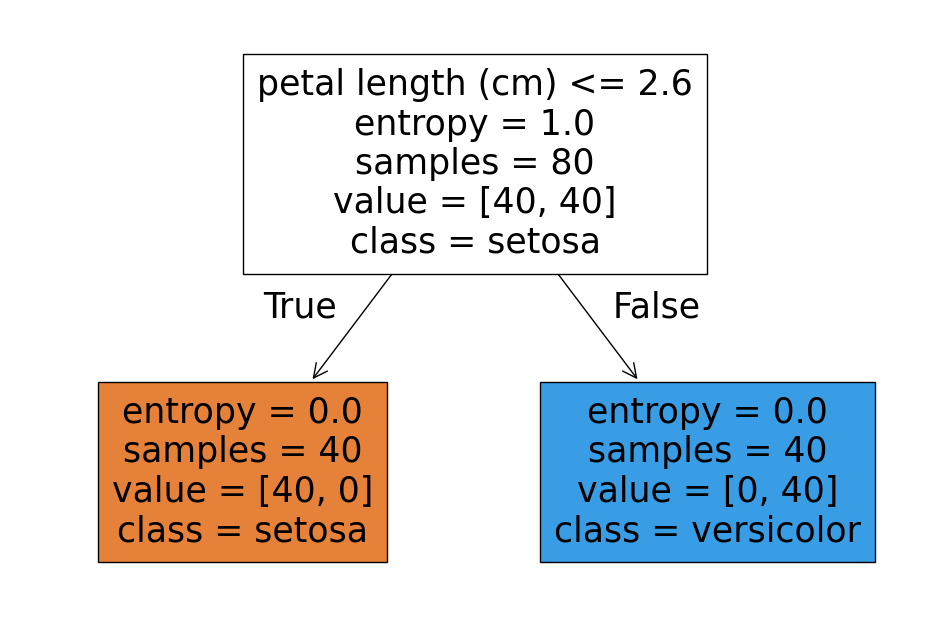

In [139]:
# Initialize the DecisionTreeClassifier
class sklearn_DecisionTree:
    def __init__(self, dataSet, dataTarget, max_depth):
        self.clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= max_depth)

        # Train the model on the training data
        self.clf.fit(dataSet, dataTarget)

    def test_DecisionTree(self, dataSet, dataTarget):
        # Predict the target labels for the test set
        Y_pred = self.clf.predict(dataSet)

        # Evaluate the accuracy of the model
        accuracy = accuracy_score(Y_pred, dataTarget)
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print()

    def plot(self):
        plt.figure(figsize=(12, 8))
        tree.plot_tree(self.clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
        plt.show()

sklearn_dT = sklearn_DecisionTree(X_train, Y_train, 3)
sklearn_dT.test_DecisionTree(X_test, Y_test)
sklearn_dT.plot()

#### Discussion

Max Depth & Accuracy/Overfitting:

Limits of max depth leads to underfitting (low accuracy) as the tree cannot capture enough patterns.
High max depth increases complexity, improving training accuracy but may cause overfitting

Limitations:

Prone to overfitting with deep trees, especially in noisy data.
Sensitive to small data changes, leading to instability.
Greedy algorithms: May not find the globally optimal split.